In [57]:
from models_otimizador import otimizador
import pandas as pd
import json
import pulp
import numpy as np
import logging
import matplotlib.pyplot as plt

%load_ext autoreload
%reload_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Iniciando dataframe de dados de entrada

In [ ]:
# dataframe com index como datas de 2024-01-01 a 2024-12-31
entradas = pd.DataFrame({
    'data': pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')})


entradas.head()

,data
0,2024-01-01
1,2024-01-02
2,2024-01-03
3,2024-01-04
4,2024-01-05


## Parâmetros

In [58]:
config = pd.read_csv('entradas/raw/tb_configuracoes.csv', index_col=0)
config.head()

,CH_CATEGORY,CH_TAG,CH_DESCRIPTION,CH_TITLE,NR_VALUE,CH_UNIT,CH_OBSERVATION
CH_ID_CONFIGURATION,,,,,,,
089f0f1d0e7e42919ad33f3e14a920f9,Default de Parâmetros de criação de cenários,TM_BOGCTE,"Tempo máximo, em segundos, de execução da simu...",Tempo máximo de execução para BOG constante (s),600,s,NaN
1c62d914038f46d1af487b895fa43f39,Composição da carga de GNL padrão,NC5,Percentual molar de n-pentano,n-C5,"0,01",%,NaN
1c870480b7e842168c4cc35eed7ecd8b,Parâmetros para simulações,MAX_INVENTORY,Nível máximo do inventário.,Inventário Máx.,165285,m³GNL,NaN
21ad3ca4b7e04b518edb65b1788c8d22,Default de Parâmetros de criação de cenários,K,Custo fixo de recebimento de carga devido à de...,Custo fixo da operação STS,500000,US$,NaN
257ee827771648c89c210c71d9758299,Parâmetros para simulações,GER_DIARIA_UTE_PSI,Capacidade máxima de geração da UTE PS-I,Geração Máx. UTE PS-I,1516,MW,NaN


In [59]:
MJ_MMBTU = config[config["CH_TAG"] == "MJ_MMBTU"]["NR_VALUE"].values[0]
# replace , for . 
MJ_MMBTU = float(str(MJ_MMBTU).replace(",","."))

KG_M3GNL = config[config["CH_TAG"] == "KG_M3GNL"]["NR_VALUE"].values[0]
# replace , for .
KG_M3GNL = float(str(KG_M3GNL).replace(",","."))

MJ_KG = config[config["CH_TAG"] == "MJ_KG"]["NR_VALUE"].values[0]
# replace , for .
MJ_KG = float(str(MJ_KG).replace(",","."))

M3GNL_MMBTU = (MJ_MMBTU / MJ_KG) * (1 / KG_M3GNL)



In [60]:
M3GNL_MMBTU

0.043793275571060365

In [76]:
config.loc[config["CH_CATEGORY"]=="Default de Parâmetros de criação de cenários",["CH_TAG","NR_VALUE"]]

,CH_TAG,NR_VALUE
CH_ID_CONFIGURATION,,
089f0f1d0e7e42919ad33f3e14a920f9,TM_BOGCTE,600
21ad3ca4b7e04b518edb65b1788c8d22,K,500000
27420050b5fe47f0846103ac3579301e,S0,0
342d7c0d1b1143e6a0a420d285d1076b,Q2,150000
4eb11ad9adb6493b8d3b2209d3725141,DW,10
58932e6f511142598238ac4aa6928f8d,BOGCTE,1
69cb12c97a00477986d496eba041575f,BG,100
882beb72813c46b8b84b79f0a06b60c7,SMIN_FLEX,1
9ba53e52882d4059b2a3a124e57d7700,TM_BOGLEVEL,1200


# Construção dos parâmetros de preço


## Dados de entrada de preço de GNL 
fonte: https://www.gov.br/mme/pt-br/assuntos/secretarias/petroleo-gas-natural-e-biocombustiveis/publicacoes-1/boletim-mensal-de-acompanhamento-da-industria-de-gas-natural/2024/12-boletim-de-acompanhamento-da-industria-de-gas-natural-dezembro-de-2024.pdf

Dados de jan a dez de 2024
- Spot LNG FOB Brazil  em US$/MMBtu: pag 15
- Petróleo Brent em US$/bbl: pag 15


In [62]:
spot_lng_fob_brazil = [8.35, 12.22, 7.93, 7.92, 27.62, 19.31, 13.51, 13.69, 13.64, 10.19, 9.40, 8.93]
brent_crude_oil = [80.23, 83.76, 85.45,90.05 ,81.75 ,82.25 ,85.15 ,80.36 ,74.02 ,75.63 ,74.35 ,73.86 ]

dolar_data = pd.read_csv('entradas/raw/USD_BRL Dados Históricos.csv',parse_dates=['Data'], dayfirst=True,index_col='Data')
# replace , for . and convert to float
dolar_data['Último'] = dolar_data['Último'].str.replace(',','.').astype(float)
dolar_data.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-12-31,6.1778,"6,1778","6,1778","6,1778",NaN,"0,00%"
2024-12-30,6.1778,"6,2030","6,2428","6,1518",NaN,"-0,30%"
2024-12-27,6.1964,"6,1834","6,2159","6,1693",NaN,"0,22%"
2024-12-26,6.1828,"6,1602","6,1982","6,1462",NaN,"-0,13%"
2024-12-25,6.1906,"6,1906","6,1906","6,1906",NaN,"0,00%"


In [63]:
# Criar dataframe com índice diário com datas de 2024-01-01 a 2024-12-31
date_range = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
df_daily = pd.DataFrame(index=date_range)
# Adicionar dados de entrada ao dataframe repetindo valores mensais para cada dia do mês
df_daily['spot_lng_fob_brazil'] = np.repeat(spot_lng_fob_brazil, [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
df_daily['brent_crude_oil'] = np.repeat(brent_crude_oil, [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# adicionar coluna com valor do dólar para cada dia a partir da coluna "último" do dataframe dolar_data
df_daily['dolar_brl'] = dolar_data['Último'].resample('D').ffill().reindex(date_range)

df_daily.head()

,spot_lng_fob_brazil,brent_crude_oil,dolar_brl
2024-01-01,8.35,80.23,4.8526
2024-01-02,8.35,80.23,4.9235
2024-01-03,8.35,80.23,4.9198
2024-01-04,8.35,80.23,4.8968
2024-01-05,8.35,80.23,4.8743


In [64]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Freq: D
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   spot_lng_fob_brazil  366 non-null    float64
 1   brent_crude_oil      366 non-null    float64
 2   dolar_brl            366 non-null    float64
dtypes: float64(3)
memory usage: 11.4 KB


## Cálculo do preço spot

In [65]:
df_daily["PS"] = df_daily["spot_lng_fob_brazil"] * df_daily["dolar_brl"] / M3GNL_MMBTU
df_daily.head()

,spot_lng_fob_brazil,brent_crude_oil,dolar_brl,PS
2024-01-01,8.35,80.23,4.8526,925.238167
2024-01-02,8.35,80.23,4.9235,938.756566
2024-01-03,8.35,80.23,4.9198,938.051093
2024-01-04,8.35,80.23,4.8968,933.665716
2024-01-05,8.35,80.23,4.8743,929.375674


Adicionando ao dataframe de entradas

In [71]:
entradas["PS"] = df_daily["PS"].values
entradas.head()

,data,PS
0,2024-01-01,925.238167
1,2024-01-02,938.756566
2,2024-01-03,938.051093
3,2024-01-04,933.665716
4,2024-01-05,929.375674


## Cálculo do preço do contrato de longo termo

In [66]:
coef_equiv = 26.8081
fator_brent = 0.12
df_daily["LCP_0_0"] = 0.122 * df_daily["brent_crude_oil"] * df_daily["dolar_brl"]/M3GNL_MMBTU
df_daily["LCP_0_1"] = 0.12 * df_daily["brent_crude_oil"] * df_daily["dolar_brl"]/M3GNL_MMBTU
df_daily["LCP_0_2"] = 0.11 * df_daily["brent_crude_oil"] * df_daily["dolar_brl"]/M3GNL_MMBTU
df_daily.head()

,spot_lng_fob_brazil,brent_crude_oil,dolar_brl,PS,LCP_0_0,LCP_0_1,LCP_0_2
2024-01-01,8.35,80.23,4.8526,925.238167,1084.585232,1066.805146,977.904718
2024-01-02,8.35,80.23,4.9235,938.756566,1100.431808,1082.391942,992.192614
2024-01-03,8.35,80.23,4.9198,938.051093,1099.604836,1081.578527,991.446983
2024-01-04,8.35,80.23,4.8968,933.665716,1094.464198,1076.522162,986.811981
2024-01-05,8.35,80.23,4.8743,929.375674,1089.435313,1071.575717,982.277741


Adicionando ao dataframe de entradas

In [72]:
entradas["LCP_0_0"] = df_daily["LCP_0_0"].values
entradas["LCP_0_1"] = df_daily["LCP_0_1"].values
entradas["LCP_0_2"] = df_daily["LCP_0_2"].values
entradas.head()

,data,PS,LCP_0_0,LCP_0_1,LCP_0_2
0,2024-01-01,925.238167,1084.585232,1066.805146,977.904718
1,2024-01-02,938.756566,1100.431808,1082.391942,992.192614
2,2024-01-03,938.051093,1099.604836,1081.578527,991.446983
3,2024-01-04,933.665716,1094.464198,1076.522162,986.811981
4,2024-01-05,929.375674,1089.435313,1071.575717,982.277741


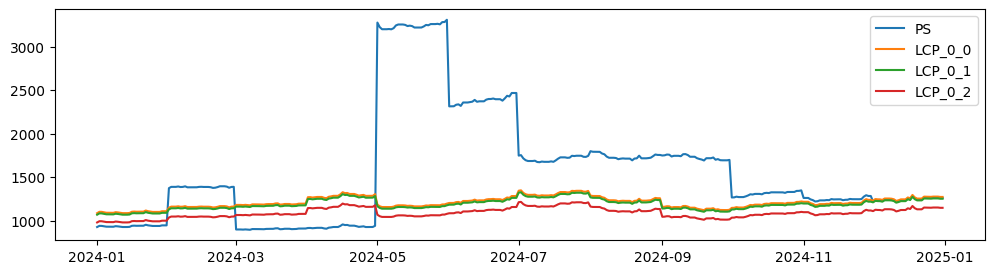

In [68]:
# plot PS and LNGC_0, LNGC_1, LNGC_2
plt.figure(figsize=(12,3))
plt.plot(df_daily.index, df_daily["PS"], label="PS")
plt.plot(df_daily.index, df_daily["LCP_0_0"], label="LCP_0_0")
plt.plot(df_daily.index, df_daily["LCP_0_1"], label="LCP_0_1")
plt.plot(df_daily.index, df_daily["LCP_0_2"], label="LCP_0_2")
plt.legend()
plt.show()